In [1]:
import pickle
from os.path import join
from os import listdir

import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn import metrics
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.metrics import precision_recall_curve, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression

import UD_draft_model.data_processing.create_model_data as create_model_data
# https://neptune.ai/blog/evaluation-metrics-binary-classification

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 300)

DATA_FOLDER = '/home/cdelong/Python-Projects/UD-Draft-Model/Repo-Work/UD-Draft-Model/data'
RANKS_FOLDER = '/home/cdelong/Python-Projects/UD-Draft-Model/Repo-Work/UD-Draft-Model\
/data/2022/player_ranks'

NUM_PLAYERS = 200


class ModelVersion:
    """ 
    Allows a model to be saved along with additional metadata.

    TODO: Update init to accept an instance of a model object.
    """

    _metatdata_items = [
        'model', 'model_number', 'data_number', 'model_description', 'features'
    ]

    def __init__(self, model, metadata: dict) -> None:
        self.model = model
        self.metadata = ModelVersion._validate_metadata(metadata)

    @staticmethod
    def _validate_metadata(metadata: dict) -> dict:
        """ 
        Ensures all required metadata items are included
        """

        for item in ModelVersion._metatdata_items:
            if item not in(metadata.keys()):
                raise Exception(f'{item} is a required metadata item')

        return metadata

    def _model_name(self) -> str:
        """ 
        Creates a unique model name that will be used to save the model.
        """

        model = self.metadata['model']
        data_number = self.metadata['data_number']
        model_number = self.metadata['model_number']
        
        return f'{model}_{data_number}_{model_number}'

    def pickle_obj(self, path: str, overwrite: bool=False) -> None:
        """
        Save the object as a pickle file.
        """

        filename = self._model_name()

        if overwrite == False:
            files = listdir(path)

            if filename in(files):
                print(f'{filename} already exists')

                return None

        # This will only run if overwrite is true or the file does not exist.
        dbfile = open(join(path, filename), 'wb')
        
        pickle.dump(self, dbfile)                     
        dbfile.close()


def split_by_draft(df: pd.DataFrame, draft_col: str=None,
     test_size: float=0.2
) -> pd.DataFrame:
    """
    Splits the data into train/test dfs by draft.
    """

    if draft_col is None:
        draft_col = 'draft_id'

    splitter = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state=7)
    split = splitter.split(df, groups=df[draft_col])
    train_inds, test_inds = next(split)

    df_train = df.iloc[train_inds]
    df_test = df.iloc[test_inds]

    return df_train, df_test


def fit_model(df_train: pd.DataFrame, features: list
    , response: str, **kwargs
) -> LogisticRegression:
    """
    Fits a logistic regression model to the training data passed.
    """

    x_train = df_train[features]
    y_train = df_train[response]

    log = LogisticRegression(**kwargs)
    log.fit(x_train, y_train)

    return log


def merge_prediction(df: pd.DataFrame, pred: np.array, out_col: str) -> pd.DataFrame:
    """ 
    Merges the model's predicions back onto the full df.
    """

    df = df.copy()
    df.reset_index(inplace=True, drop=True)

    pred = pd.DataFrame(pred, columns=[out_col])

    df = pd.concat([df, pred], axis=1)

    return df


def load_obj(file_path: str):
    dbfile = open(file_path, 'rb')
    obj = pickle.load(dbfile)
    dbfile.close()

    return obj

df_model = create_model_data.create_model_data(DATA_FOLDER, [2021, 2022], 200)

df_train, df_test = split_by_draft(df_model.copy(), draft_col='draft_id'
    , test_size=0.2
)

In [19]:
features = ['diff_cur_rank_picks_btwn', 'ind_rank_btwn']
target = 'ind_picked'

x_train = df_train[features]
y_train = df_train[target]

model_metadata = {
    'model': 'LogisticRegression',
    'model_number': 'v001',
    'data_number': 'v01',
    'model_description': 'logistic regression with # of picks between and '
        'indicator for picks between',
    'target': target,
    'features': features
}
log = fit_model(df_train.copy(), features, target)
mv = ModelVersion(log, model_metadata)
mv.pickle_obj(join(DATA_FOLDER, 'models'), overwrite=True)

x_test = df_test[features]
y_test = df_test[target]

y_pred = log.predict(x_test)

y_pred_prob = log.predict_proba(x_test)
y_pred_prob = y_pred_prob[:,1]

loss = brier_score_loss(y_test, y_pred_prob)

df_test_w_pred = merge_prediction(df_test, y_pred, 'pred')
df_test_w_pred = merge_prediction(df_test_w_pred, y_pred_prob, 'pred_prob')

loss

# log.pickle_obj(join(DATA_FOLDER, 'models'), overwrite=True)

0.026780912689744762

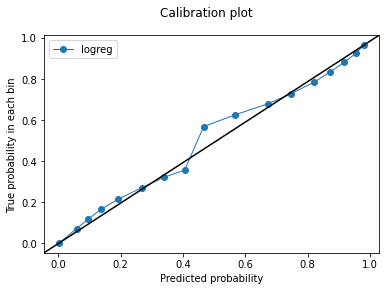

In [20]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

# _df = df_test_w_pred.loc[df_test_w_pred['diff_cur_rank_picks_btwn'] <= 10]
_df = df_test_w_pred

y_actual = _df[target]
y_pred = _df['pred_prob']

actual, pred = calibration_curve(y_actual, y_pred, n_bins=20)
# actual, pred = calibration_curve(y_test, y_pred_prob, n_bins=20)
# actual, pred = calibration_curve(y_test_new, y_pred_prob_new, n_bins=20)
# actual, pred = calibration_curve(y_test_filt, y_pred_prob_filt, n_bins=40, strategy='quantile')

fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(actual, pred, marker='o', linewidth=1, label='logreg')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

In [ ]:
###############################################################################
################################## SCRATCH ####################################
###############################################################################

In [57]:
_df = df_model.copy()

conds = ((_df['draft_id'] == '133d89ab-ba4f-4230-9148-396bee781f5c')
        & (_df['number'] == 11)
        # & (_df['avail_cur_rank_actual'] == 1)
        # & (_df['draft_entry_id'] == 'c488824b-b11d-42f0-b16c-e59fc361e425')
        )
_df.loc[conds]

,drafted_player_key,avail_player_key,avail_rank_actual,avail_team,avail_position,avail_projection_adp,appearance_id,created_at,draft_entry_id,number,projection_adp,draft_id,draft_source,draft_title,num_teams,round,round_pick,draft_datetime,draft_date,draft_year,ranks_type,drafted_player,drafted_team,drafted_position,ranks_draft_date,avail_number,next_pick_number,ind_avail,avail_cur_rank_actual,picks_btwn,diff_cur_rank_picks_btwn,ind_rank_btwn,ind_picked
4776325,Davante Adams - 2022-05-15 - 9.9,Davante Adams - 2022-05-15 - 9.9,9,LV,WR,9.9,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,11.0,14.0,0,1,3.0,-2.0,1,1
4776326,Davante Adams - 2022-05-15 - 9.9,Joe Mixon - 2022-05-15 - 12.2,12,CIN,RB,12.2,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,12.0,14.0,0,2,3.0,-1.0,1,1
4776327,Davante Adams - 2022-05-15 - 9.9,Travis Kelce - 2022-05-15 - 12.6,13,KC,TE,12.6,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,13.0,14.0,0,3,3.0,0.0,1,1
4776328,Davante Adams - 2022-05-15 - 9.9,CeeDee Lamb - 2022-05-15 - 14.3,14,DAL,WR,14.3,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,14.0,14.0,1,4,3.0,1.0,0,0
4776329,Davante Adams - 2022-05-15 - 9.9,Deebo Samuel - 2022-05-15 - 16.6,15,SF,WR,16.6,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,18.0,14.0,1,5,3.0,2.0,0,0
4776330,Davante Adams - 2022-05-15 - 9.9,Mark Andrews - 2022-05-15 - 17.3,16,BAL,TE,17.3,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,15.0,14.0,1,6,3.0,3.0,0,0
4776331,Davante Adams - 2022-05-15 - 9.9,D'Andre Swift - 2022-05-15 - 17.6,17,DET,RB,17.6,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,16.0,14.0,1,7,3.0,4.0,0,0
4776332,Davante Adams - 2022-05-15 - 9.9,Alvin Kamara - 2022-05-15 - 19.1,18,NO,RB,19.1,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,17.0,14.0,1,8,3.0,5.0,0,0
4776333,Davante Adams - 2022-05-15 - 9.9,Tyreek Hill - 2022-05-15 - 20.1,19,MIA,WR,20.1,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,26.0,14.0,1,9,3.0,6.0,0,0
4776334,Davante Adams - 2022-05-15 - 9.9,Mike Evans - 2022-05-15 - 20.2,20,TB,WR,20.2,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,20.0,14.0,1,10,3.0,7.0,0,0


In [6]:
_df = df_final.groupby('ind_avail').size().to_frame('num_players').reset_index()
_df['perc_players'] = _df['num_players'] / len(df_final)

_df

,ind_avail,num_players,perc_players
0,0,438328,0.093861
1,1,4231630,0.906139


In [49]:
splitter = GroupShuffleSplit(test_size=0.20, n_splits=10, random_state=7)
split = splitter.split(df, groups=df['draft_id'])
a = [1, 2]

for i, check in enumerate(split):
    if i == 0:
        print(len(check[1]))
    else:
        break

1024242


In [40]:
# _df = df_train.copy()
# _df = _df.groupby(['draft_year'], dropna=False)['draft_id'].nunique().to_frame('num_picks')

num_train = df_train['draft_id'].nunique()
num_test = df_test['draft_id'].nunique()

print(num_train)
print(num_test)
print(num_train + num_test)
print(df_model['draft_id'].nunique())
print(num_train / (num_train + num_test))

124
32
156
156
0.7948717948717948


In [12]:
# accuracy = metrics.accuracy_score(y_test, y_pred)
# accuracy_percentage = 100 * accuracy

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(recall)
print(precision)

0.7931172291296625
0.7931172291296625


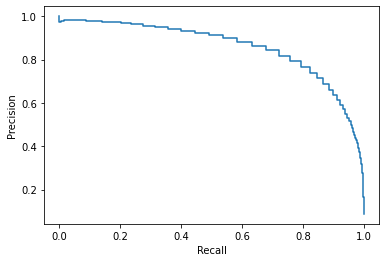

In [13]:
precision, recall, threshold = precision_recall_curve(y_test, 
                                                      y_pred_prob)
prd = PrecisionRecallDisplay(precision, recall)
prd.plot()

In [25]:
# precision[196:]
# recall[197:]
threshold[196:]

array([0.35637088, 0.56847159, 0.60674675, 0.64375449, 0.67912138,
       0.71254498, 0.74380048, 0.77274141, 0.79929527, 0.82345531,
       0.84527006, 0.86483174, 0.8822648 , 0.89771539, 0.91134213,
       0.92330855, 0.93377719, 0.94290519, 0.95084124, 0.95772366,
       0.96367933, 0.9688233 , 0.97325896, 0.97707847, 0.98036344])

In [11]:
_df = df_train.copy()
_df = _df.groupby(['draft_year'], dropna=False)['draft_id'].nunique().to_frame('num_picks')

_df

,num_picks
draft_year,
2021,88
2022,36
